### Tree models for hotel reservation cancelation prediction

In this notebook, we train decision tree and gradient boosted tree models to predict whether a hotel reservation will be canceled or not. The data used in this notebook comes from Kaggle page "Hotel Reservations Dataset" [https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset]. 

In [22]:
# import packages
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#Pre/pos-processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support as score

#Decision Trees
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#XGBoost
import xgboost as xgb
import graphviz

#Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [2]:
# read in data
df = pd.read_csv('Hotel Reservations.csv')

### Understanding the Data

In [3]:
# data cleaning
df.isna().any()
print('Data is clean!')

Data is clean!


The data set has some categorical features that will need to be encoded as integers before training the model.

In [4]:
# print feature and data type of feature
cols = {}
for col in df.columns:
    cols[col] = type(df.loc[0,col])
    
print(pd.DataFrame.from_dict(cols, orient='index'))
df.describe().round(2)


                                                            0
Booking_ID                                      <class 'str'>
no_of_adults                            <class 'numpy.int64'>
no_of_children                          <class 'numpy.int64'>
no_of_weekend_nights                    <class 'numpy.int64'>
no_of_week_nights                       <class 'numpy.int64'>
type_of_meal_plan                               <class 'str'>
required_car_parking_space              <class 'numpy.int64'>
room_type_reserved                              <class 'str'>
lead_time                               <class 'numpy.int64'>
arrival_year                            <class 'numpy.int64'>
arrival_month                           <class 'numpy.int64'>
arrival_date                            <class 'numpy.int64'>
market_segment_type                             <class 'str'>
repeated_guest                          <class 'numpy.int64'>
no_of_previous_cancellations            <class 'numpy.int64'>
no_of_pr

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00
mean,1.84,0.11,0.81,2.20,0.03,85.23,2017.82,7.42,15.60,0.03,0.02,0.15,103.42,0.62
std,0.52,0.40,0.87,1.41,0.17,85.93,0.38,3.07,8.74,0.16,0.37,1.75,35.09,0.79
min,0.00,0.00,0.00,0.00,0.00,0.00,2017.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,0.00,0.00,1.00,0.00,17.00,2018.00,5.00,8.00,0.00,0.00,0.00,80.30,0.00
50%,2.00,0.00,1.00,2.00,0.00,57.00,2018.00,8.00,16.00,0.00,0.00,0.00,99.45,0.00
75%,2.00,0.00,2.00,3.00,0.00,126.00,2018.00,10.00,23.00,0.00,0.00,0.00,120.00,1.00
max,4.00,10.00,7.00,17.00,1.00,443.00,2018.00,12.00,31.00,1.00,13.00,58.00,540.00,5.00


In [5]:
# an example of one data point
df.loc[0,:]

Booking_ID                                  INN00001
no_of_adults                                       2
no_of_children                                     0
no_of_weekend_nights                               1
no_of_week_nights                                  2
type_of_meal_plan                        Meal Plan 1
required_car_parking_space                         0
room_type_reserved                       Room_Type 1
lead_time                                        224
arrival_year                                    2017
arrival_month                                     10
arrival_date                                       2
market_segment_type                          Offline
repeated_guest                                     0
no_of_previous_cancellations                       0
no_of_previous_bookings_not_canceled               0
avg_price_per_room                              65.0
no_of_special_requests                             0
booking_status                          Not_Ca

In [6]:
# categorical data
print(df.groupby('type_of_meal_plan').size())
print('---------------------------')
print(df.groupby('room_type_reserved').size())
print('---------------------------')
print(df.groupby('market_segment_type').size())
print('---------------------------')
print(df.groupby('booking_status').size())

type_of_meal_plan
Meal Plan 1     27835
Meal Plan 2      3305
Meal Plan 3         5
Not Selected     5130
dtype: int64
---------------------------
room_type_reserved
Room_Type 1    28130
Room_Type 2      692
Room_Type 3        7
Room_Type 4     6057
Room_Type 5      265
Room_Type 6      966
Room_Type 7      158
dtype: int64
---------------------------
market_segment_type
Aviation           125
Complementary      391
Corporate         2017
Offline          10528
Online           23214
dtype: int64
---------------------------
booking_status
Canceled        11885
Not_Canceled    24390
dtype: int64


In [7]:
# convert the booking_status (i.e. the label) into a boolean variable
df['booking_status_bln'] = df['booking_status'].apply(lambda x: True if x == 'Canceled' else False)

In [8]:
# print the proportion of cancelations for each category 
# to get a feel for the importantfeatures
df_bs = df.groupby('booking_status').size()
print('Proportion of all reservations canceled: ' + str(df_bs['Canceled']/len(df)))
print('-------------------------')

#proportion of reservations in each category that canceled
for col in df.columns[1:]:
    print(df.groupby(col).apply(lambda x: x['booking_status_bln'].sum()/len(x)))
    print('-------------------------')

Proportion of all reservations canceled: 0.32763611302549966
-------------------------
no_of_adults
0    0.316547
1    0.241196
2    0.349280
3    0.372464
4    0.187500
dtype: float64
-------------------------
no_of_children
0     0.324091
1     0.333745
2     0.431947
3     0.263158
9     0.500000
10    0.000000
dtype: float64
-------------------------
no_of_weekend_nights
0    0.301861
1    0.343372
2    0.348032
3    0.483660
4    0.643411
5    0.852941
6    0.800000
7    1.000000
dtype: float64
-------------------------
no_of_week_nights
0     0.284457
1     0.271079
2     0.349266
3     0.328358
4     0.382274
5     0.391574
6     0.465608
7     0.460177
8     0.516129
9     0.617647
10    0.854839
11    0.823529
12    0.777778
13    1.000000
14    0.571429
15    0.800000
16    1.000000
17    0.666667
dtype: float64
-------------------------
type_of_meal_plan
Meal Plan 1     0.311802
Meal Plan 2     0.455673
Meal Plan 3     0.200000
Not Selected    0.331189
dtype: float64
-------

### Feature Engineering and Encoding

In [9]:
# example to automate the ordinal categorical variable encoding

col = 'room_type_reserved'
room_df = df.groupby(col).apply(lambda x: x['booking_status_bln'].sum()/len(x))
room_df.sort_values(ascending = False, inplace = True)
room_df = room_df.to_frame()
room_df.insert(0, 'New_ID', range(1,1+len(room_df)))
room_df = room_df['New_ID'].to_dict()
room_df

{'Room_Type 6': 1,
 'Room_Type 4': 2,
 'Room_Type 2': 3,
 'Room_Type 1': 4,
 'Room_Type 3': 5,
 'Room_Type 5': 6,
 'Room_Type 7': 7}

In [10]:
# data encoding

str_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']
en_cols = ['meal_en', 'room_en', 'market_en']

# encode the features in str_cols
# encoded features are called in en_cols

for i in range(3):
    col = str_cols[i]
    en_col = en_cols[i]
    
    en_df = df.groupby(col).apply(lambda x: x['booking_status_bln'].sum()/len(x))
    en_df.sort_values(ascending = False, inplace = True)
    en_df = en_df.to_frame()
    en_df.insert(0, 'New_ID', range(1,1+len(en_df)))
    en_dict = en_df['New_ID'].to_dict()
    
    df[en_col] = df[col].map(en_dict)

In [11]:
# sanity check

df[['type_of_meal_plan','meal_en']].head(10)
#df[['room_type_reserved','room_en']].head(50)
#df[['market_segment_type','market_en']].head(50)

,type_of_meal_plan,meal_en
0,Meal Plan 1,3
1,Not Selected,2
2,Meal Plan 1,3
3,Meal Plan 1,3
4,Not Selected,2
5,Meal Plan 2,1
6,Meal Plan 1,3
7,Meal Plan 1,3
8,Meal Plan 1,3
9,Meal Plan 1,3


### Model Training

In [12]:
# examine columns for feature selection

cols = df.columns

i = 0
for col in cols:
    print(i,col)
    i+=1

0 Booking_ID
1 no_of_adults
2 no_of_children
3 no_of_weekend_nights
4 no_of_week_nights
5 type_of_meal_plan
6 required_car_parking_space
7 room_type_reserved
8 lead_time
9 arrival_year
10 arrival_month
11 arrival_date
12 market_segment_type
13 repeated_guest
14 no_of_previous_cancellations
15 no_of_previous_bookings_not_canceled
16 avg_price_per_room
17 no_of_special_requests
18 booking_status
19 booking_status_bln
20 meal_en
21 room_en
22 market_en


In [13]:
# feature selection

feats = cols[[1,2,3,4,6,8,9,10,11,13,14,15,16,17,20,21,22]]
X = df[feats]
y = df[cols[19]]

In [14]:
# rescale data for better performance

mms = MinMaxScaler()
X_scaled = mms.fit_transform(X)
X_scaled

array([[0.5       , 0.        , 0.14285714, ..., 0.66666667, 0.5       ,
        0.25      ],
       [0.5       , 0.        , 0.28571429, ..., 0.33333333, 0.5       ,
        0.        ],
       [0.25      , 0.        , 0.28571429, ..., 0.66666667, 0.5       ,
        0.        ],
       ...,
       [0.5       , 0.        , 0.28571429, ..., 0.66666667, 0.5       ,
        0.        ],
       [0.5       , 0.        , 0.        , ..., 0.33333333, 0.5       ,
        0.        ],
       [0.5       , 0.        , 0.14285714, ..., 0.66666667, 0.5       ,
        0.25      ]])

In [15]:
# train/val/test split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size = .8, random_state = 0)

In [16]:
# examine data

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_test_df = pd.DataFrame(X_test)
X_test_df

(29020, 17)
(7255, 17)
(29020,)
(7255,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.75,0.0,0.285714,0.176471,0.0,0.049661,1.0,0.272727,0.433333,0.0,0.0,0.0,0.282593,0.4,0.666667,0.166667,0.00
1,0.50,0.0,0.000000,0.176471,0.0,0.435666,0.0,0.818182,0.466667,0.0,0.0,0.0,0.120370,0.0,0.666667,0.500000,0.25
2,0.50,0.0,0.000000,0.117647,0.0,0.580135,0.0,0.545455,0.000000,0.0,0.0,0.0,0.187963,0.0,0.000000,0.500000,0.25
3,0.50,0.0,0.285714,0.235294,0.0,0.015801,1.0,0.454545,0.500000,0.0,0.0,0.0,0.288889,0.2,0.666667,0.166667,0.00
4,0.50,0.0,0.000000,0.117647,0.0,0.088036,0.0,0.636364,0.433333,0.0,0.0,0.0,0.187963,0.0,0.000000,0.500000,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7250,0.50,0.0,0.285714,0.176471,0.0,0.198646,1.0,0.727273,0.466667,0.0,0.0,0.0,0.276667,0.2,0.666667,0.166667,0.00
7251,0.50,0.0,0.285714,0.000000,0.0,0.024831,1.0,0.454545,0.833333,0.0,0.0,0.0,0.214815,0.0,0.666667,0.500000,0.00
7252,0.50,0.0,0.000000,0.117647,0.0,0.117381,1.0,0.090909,0.600000,0.0,0.0,0.0,0.145000,0.2,0.666667,0.500000,0.00
7253,0.25,0.0,0.285714,0.000000,0.0,0.072235,1.0,1.000000,0.100000,0.0,0.0,0.0,0.211111,0.0,0.666667,0.166667,0.00


### Decision Tree Model

In [17]:
# smaller ccp_alpha gives deeper trees (limited by max_depth)

dt = DecisionTreeClassifier(max_depth=4, ccp_alpha=0.01, criterion='entropy')
dt.fit(X_train, y_train)

print('DT Training Score: ' + str(dt.score(X_train, y_train)))
print('DT Test Score: ' + str((dt.score(X_test, y_test))))

DT Training Score: 0.8155410062026189
DT Test Score: 0.8205375603032391


In [18]:
# feature importances (sorted)

DT_feat_imp_L = [[feats[i],dt.feature_importances_[i]] for i in range(len(feats))]
DT_feat_imp_df = pd.DataFrame(data = DT_feat_imp_L).sort_values(ascending = False, by = 1).reset_index(drop = True)
DT_feat_imp_df

,0,1
0,lead_time,0.471006
1,market_en,0.208341
2,no_of_special_requests,0.176266
3,avg_price_per_room,0.108347
4,arrival_month,0.036041
5,no_of_previous_cancellations,0.000000
6,room_en,0.000000
7,meal_en,0.000000
8,no_of_previous_bookings_not_canceled,0.000000
9,no_of_adults,0.000000


|--- lead_time <= 0.34
|   |--- no_of_special_requests <= 0.10
|   |   |--- market_en <= 0.12
|   |   |   |--- lead_time <= 0.02
|   |   |   |   |--- weights: [1085.00, 283.00] class: 0.0
|   |   |   |--- lead_time >  0.02
|   |   |   |   |--- weights: [1776.00, 2827.00] class: 1.0
|   |   |--- market_en >  0.12
|   |   |   |--- lead_time <= 0.17
|   |   |   |   |--- weights: [4068.00, 336.00] class: 0.0
|   |   |   |--- lead_time >  0.17
|   |   |   |   |--- weights: [1253.00, 564.00] class: 0.0
|   |--- no_of_special_requests >  0.10
|   |   |--- weights: [9760.00, 1343.00] class: 0.0
|--- lead_time >  0.34
|   |--- avg_price_per_room <= 0.19
|   |   |--- no_of_special_requests <= 0.10
|   |   |   |--- market_en <= 0.12
|   |   |   |   |--- weights: [18.00, 708.00] class: 1.0
|   |   |   |--- market_en >  0.12
|   |   |   |   |--- weights: [766.00, 741.00] class: 0.0
|   |   |--- no_of_special_requests >  0.10
|   |   |   |--- weights: [689.00, 274.00] class: 0.0
|   |--- avg_price_p

[Text(0.5294117647058824, 0.9, 'lead_time <= 0.342\nentropy = 0.912\nsamples = 29020\nvalue = [19536, 9484]\nclass = Canceled'),
 Text(0.29411764705882354, 0.7, 'no_of_special_requests <= 0.1\n0.778\n23295\n[17942, 5353]\nCanceled'),
 Text(0.23529411764705882, 0.5, 'market_en <= 0.125\n0.914\n12192\n[8182, 4010]\nCanceled'),
 Text(0.11764705882352941, 0.3, 'lead_time <= 0.021\n0.999\n5971\n[2861, 3110]\nNot Canceled'),
 Text(0.058823529411764705, 0.1, '0.735\n1368\n[1085, 283]\nCanceled'),
 Text(0.17647058823529413, 0.1, '0.962\n4603\n[1776, 2827]\nNot Canceled'),
 Text(0.35294117647058826, 0.3, 'lead_time <= 0.168\n0.596\n6221\n[5321, 900]\nCanceled'),
 Text(0.29411764705882354, 0.1, '0.389\n4404\n[4068, 336]\nCanceled'),
 Text(0.4117647058823529, 0.1, '0.894\n1817\n[1253, 564]\nCanceled'),
 Text(0.35294117647058826, 0.5, '0.532\n11103\n[9760, 1343]\nCanceled'),
 Text(0.7647058823529411, 0.7, 'avg_price_per_room <= 0.185\n0.853\n5725\n[1594, 4131]\nNot Canceled'),
 Text(0.647058823529

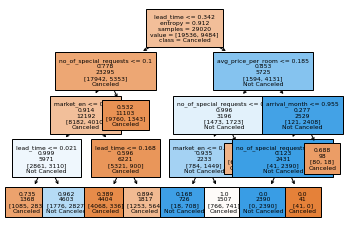

In [19]:
# plot tree

print(tree.export_text(dt, feature_names = feats.to_list(), show_weights = True))
tree.plot_tree(dt, feature_names = feats,  
               max_depth=10, class_names = ['Canceled', 'Not Canceled'],
               label='root', filled=True, fontsize = 6)


In [20]:
# At 300+ days there are days where everyone cancels and no one cancels
# Maybe this is because there is only a single party responsible for the 
# reservations on those dates.

df_group_lead = df.groupby('lead_time').apply(lambda x: x['booking_status_bln'].sum()/len(x))
df_group_lead = pd.DataFrame(df_group_lead)
df_group_lead['count'] = df.groupby('lead_time').apply(lambda x: len(x))
df_group_lead['num_cancelled'] = df.groupby('lead_time').apply(lambda x: x['booking_status_bln'].sum())

df_group_lead.reset_index(drop = False)
df_group_lead.rename(columns = {0:'prop'}, inplace = True)

In [21]:
# count = total number of reservations with a given lead_time

df_group_lead.tail(10)

,prop,count,num_cancelled
lead_time,,,
355,1.000000,1,1
359,0.250000,16,4
361,1.000000,5,5
372,1.000000,1,1
377,0.913043,69,63
381,1.000000,2,2
386,0.913043,69,63
418,1.000000,60,60
433,1.000000,20,20


### Decision Tree Model Trained via GridSearchCV

In [22]:
# train DT model with KFold validation and hyperparameter search

dt = DecisionTreeClassifier(max_depth=4, ccp_alpha=0.01, criterion='entropy')
cv = KFold(3, shuffle=True)
params = {"max_depth" : [4,10,100,1000], "ccp_alpha":np.logspace(-6,0,7)} # this should be a dictionary {"param_name" : [param, options, ...]}

gcv = GridSearchCV(estimator=dt, cv=cv, param_grid=params)

In [23]:
gcv.fit(X_train, y_train)
gcv.cv_results_

{'mean_fit_time': array([0.03303409, 0.05955691, 0.09377522, 0.09274263, 0.03190207,
        0.0594439 , 0.09172444, 0.09444432, 0.03248181, 0.05885987,
        0.09883804, 0.10139008, 0.03278842, 0.05938263, 0.11094913,
        0.11200824, 0.03192396, 0.05768375, 0.11019912, 0.11233497,
        0.03126297, 0.05747371, 0.11099129, 0.11463423, 0.03191161,
        0.05750198, 0.11341   , 0.11097331]),
 'std_fit_time': array([0.00223351, 0.00305332, 0.00403221, 0.00465745, 0.00104766,
        0.00229295, 0.00158693, 0.00431359, 0.00124282, 0.00249888,
        0.00344648, 0.00283482, 0.00228884, 0.00124898, 0.00332567,
        0.00363028, 0.00096482, 0.00195346, 0.00186535, 0.00618473,
        0.00103723, 0.00325409, 0.00441749, 0.00428234, 0.00191567,
        0.0021417 , 0.00384763, 0.00266603]),
 'mean_score_time': array([0.00188169, 0.00205603, 0.00269566, 0.00253458, 0.00190039,
        0.0022378 , 0.00217261, 0.00209007, 0.00171676, 0.00194302,
        0.00219259, 0.00223403, 0.001735

In [24]:
dt_best = gcv.best_estimator_

print(dt_best.get_params)
print('Training Score: ' + str(dt_best.score(X_train, y_train)))
print('Test Score: ' + str((dt_best.score(X_test, y_test))))
print('Decision Tree Depth: ' + str(dt_best.get_depth()))

<bound method BaseEstimator.get_params of DecisionTreeClassifier(ccp_alpha=0.0001, criterion='entropy', max_depth=1000)>
Training Score: 0.9686078566505858
Test Score: 0.867539627842867
Decision Tree Depth: 37


In [25]:
# Feature importance of the optimal model

DT_best_feat_imp_L = [[feats[i],dt_best.feature_importances_[i]] for i in range(len(feats))]
DT_best_feat_imp_df = pd.DataFrame(data = DT_best_feat_imp_L).sort_values(ascending = False, by = 1).reset_index(drop = True)
DT_best_feat_imp_df

,0,1
0,lead_time,0.322489
1,avg_price_per_room,0.169863
2,market_en,0.102516
3,arrival_month,0.094094
4,no_of_special_requests,0.083951
5,arrival_date,0.075056
6,no_of_week_nights,0.045520
7,no_of_weekend_nights,0.033862
8,no_of_adults,0.020910
9,arrival_year,0.014709


### Gradient Boosted Trees via XGBoost

First we do a few experiments

In [26]:
# make DMatrices
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = feats)
dtest = xgb.DMatrix(X_test, label = y_test, feature_names = feats)

In [27]:
#model parameters
param = {'max_depth': 15, 
         'max_features': 5,
         'eta': 1.0, 
         'objective': 'binary:hinge', 
         'lambda':10**(-1), 
         'num_parallel_tree':20,
        'random_state':0}

param['nthread'] = 4
param['eval_metric'] = 'auc'

print(param)

evallist = [(dtrain, 'train'), (dtest, 'eval')]

{'max_depth': 15, 'max_features': 5, 'eta': 1.0, 'objective': 'binary:hinge', 'lambda': 0.1, 'num_parallel_tree': 20, 'random_state': 0, 'nthread': 4, 'eval_metric': 'auc'}


In [28]:
num_round = 10
bst = xgb.train(param, dtrain, num_round)

[20:27:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.



In [29]:
ypred_train = bst.predict(dtrain)
ypred_test = bst.predict(dtest)

In [30]:
print('Training score: ' + str((ypred_train == y_train).mean()))
print('Test score: ' + str((ypred_test == y_test).mean()))

Training score: 0.9768090971743625
Test score: 0.8777394900068918


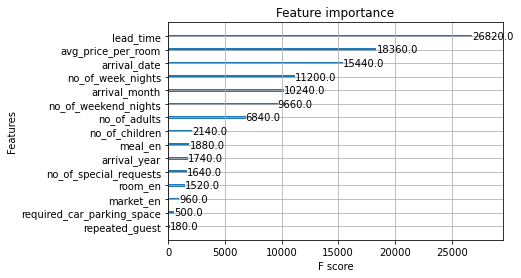

In [31]:
xgb.plot_importance(bst)
plt.show()

### Gradient Boosted Trees via XGBoost & GridSearchCV

Now we do a grid search of the parameter space.

In [32]:
xgboost = xgb.XGBClassifier()

param_grid = {'max_depth':[6,8,9,10,11,12,20,40,100]} #, 'eta':np.linspace(.1,.9,4), 'lambda':np.logspace(-7,2,8) 
scoring = ['accuracy']
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [33]:
grid_search = GridSearchCV(estimator=xgboost, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           n_jobs=-1, 
                           refit = 'accuracy',
                           cv=kfold, 
                           verbose=0)

grid_result = grid_search.fit(X_train, y_train)
grid_result

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 9, 10, 11, 12, 20, 40, 100]},
             refit='accuracy', scoring=['accuracy'])

In [34]:
print('The best training score averaged across all the validation sets is ' + str(grid_result.best_score_))

The best training score averaged across all the validation sets is 0.8930047919457472


In [35]:
# Print the best score and the corresponding hyperparameters
print(f'The best validation score is {grid_result.best_score_:.4f}')
print(f'The best hyperparameters are {grid_result.best_params_}')

The best validation score is 0.8930
The best hyperparameters are {'max_depth': 9}


In [36]:
# Make prediction using the best model
grid_pred_train = grid_search.predict(X_train)
grid_pred_test = grid_search.predict(X_test)

train_acc = (grid_pred_train == y_train).mean()
test_acc = (grid_pred_test == y_test).mean()

print('The training accuracy is ' + str(train_acc))
print('The test accuracy is ' + str(test_acc))

The training accuracy is 0.9630944176430049
The test accuracy is 0.9015851137146795


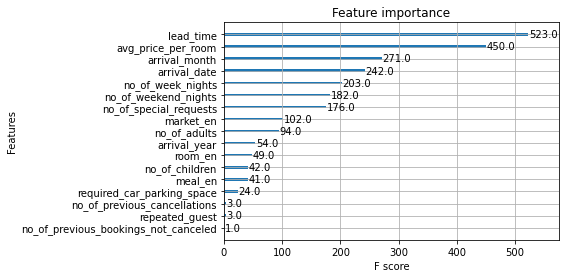

In [37]:
# plot feature importance for the optimal parameters

best_params = grid_result.best_params_
num_round = 10
bst_best = xgb.train(best_params, dtrain, num_round)

xgb.plot_importance(bst_best)
plt.show()

### Random Forest Model

In [19]:
clf = RandomForestClassifier(max_depth=25, n_estimators = 20, random_state=0, max_features = 5)
rf = clf.fit(X_train, y_train)

print('RF Training Score: ' + str(rf.score(X_train, y_train)))
print('RF Test Score: ' + str((rf.score(X_test, y_test))))

RF Training Score: 0.9888352860096485
RF Test Score: 0.9031013094417643


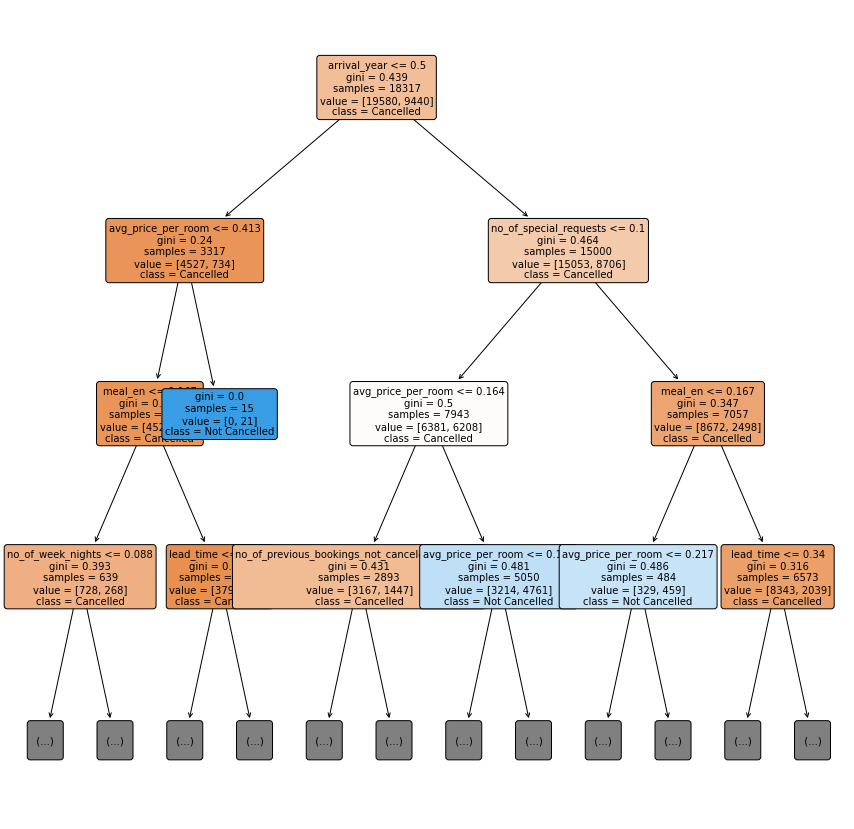

In [32]:
#example of one decision tree estimator

estimator = rf.estimators_[0]

fig = plt.figure(figsize=(15, 15))
tree.plot_tree(estimator,
               max_depth = 3,
          feature_names= feats,
          class_names= ['Cancelled', 'Not Cancelled'], 
          filled=True, 
          rounded=True,
        fontsize = 10)

plt.show()

### Random Forests via GridSearchCV

In [55]:
param_grid = {'max_depth':[10,25,30], 
              'n_estimators':[25,50,200], 
              'max_features':[3,5,7,10],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             }
scoring = ['accuracy']
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state = 0, bootstrap = True), 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           n_jobs=-1, 
                           refit = 'accuracy',
                           cv=kfold, 
                           verbose=0)

grid_result = grid_search.fit(X_train, y_train)
grid_result

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [10, 25, 30],
                         'max_features': [3, 5, 7, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [25, 50, 200]},
             refit='accuracy', scoring=['accuracy'])

In [56]:
# Make prediction using the best model
grid_pred_train = grid_search.predict(X_train)
grid_pred_test = grid_search.predict(X_test)

train_acc = (grid_pred_train == y_train).mean()
test_acc = (grid_pred_test == y_test).mean()

print('The training accuracy is ' + str(train_acc))
print('The test accuracy is ' + str(test_acc))
print(grid_search.best_params_)

The training accuracy is 0.9926946933149552
The test accuracy is 0.9064093728463128
{'max_depth': 25, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [69]:
type(grid_search.best_params_)

dict

In [73]:
clf_best = RandomForestClassifier()
clf_best.set_params(**grid_search.best_params_)
rf_best = clf_best.fit(X_train, y_train)
rf_best.feature_importances_.round(3)

array([0.025, 0.007, 0.037, 0.05 , 0.006, 0.326, 0.026, 0.078, 0.085,
       0.001, 0.   , 0.001, 0.164, 0.098, 0.02 , 0.016, 0.06 ])

In [88]:
#feature importances
imp_D = {}

for i in range(len(feats)):
    imp_D[feats[i]] = rf_best.feature_importances_[i]
    
imp_df = pd.DataFrame.from_dict(imp_D, orient = 'index')
imp_df.sort_values(by = 0, ascending = False)

,0
lead_time,0.325979
avg_price_per_room,0.164455
no_of_special_requests,0.098325
arrival_date,0.085364
arrival_month,0.077877
market_en,0.059751
no_of_week_nights,0.049580
no_of_weekend_nights,0.036735
arrival_year,0.025904
no_of_adults,0.024909


### Conclusions

The above analysis trains decision tree, gradient boosted tree, and random forest models using a 3-fold validation with an 80/20 train/test split of the data. Each model was tuned using GridSearchCV. 

The decisions tree model predicted cancellation with 87% accuracy. The XGBoost and Random Forest models predicted cancellation with 90%-91% accuracy.  

Feature importances were calculated for each of these models. In all cases, the first and second most important features were lead_time and avg_price_per_room, respectively. The third most important feature varied by model. (Note that feature importance of the gradient boosted trees were calculated via F score, while the decision tree and random forest models were calculated by Gini importance.) 